In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import warnings
# module_path = os.path.abspath(os.path.join('TF_net'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from train import Dataset, train_epoch, eval_epoch, test_epoch, Scaler, preprocess
from args import parse_arguments
import torch.nn as nn
from torch.utils import data
from scipy import stats
from pathlib import Path
import numpy as np
from model_addon import LES

def describe(x, axis=None):
    return stats.describe(x, axis)

In [7]:
args = parse_arguments("")
args.data = 'rbc_data.pt'

if args.data == "rbc_data.pt":
    compress = True
    permute = False
    offset=0
    transform_type = 'std'
    test_mode_train = False
elif args.data == 'data5.pt':
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
    split_spatially = False
elif 'data' in args.data and '101' in args.data:
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
    test_mode_train = True
else:
    raise ValueError("Un expected data file name")
args.transform = Scaler(transform_type, offset)


if Path(args.data).name == args.data: args.data = "../" + args.data #============================= extra line ========================================

data_prep = preprocess(args, permute, compress, test_mode=True)

tensor([-0.8027])
tensor([4503.7119]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7f8a28826f70> <function Scaler.fit_transform.<locals>.<lambda> at 0x7f8a28826f70>


torch.Size([64, 448])
DescribeResult(nobs=13312, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)


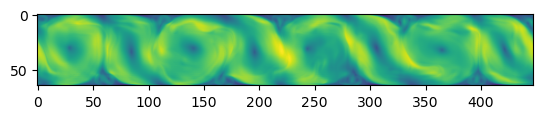

In [8]:
def plot_dft():
    idx=0
    signal = torch.linalg.norm(data_prep[idx], dim=0)
    print(signal.shape)
    fig, ax3 = plt.subplots(ncols=1)
    # ax1.imshow(signal)
    dft = torch.fft.fft2(signal)
    cutoff = int(0.5 * 64 )
    dft[cutoff:, cutoff:] = 0.0
    # ax2.imshow(torch.real(dft))
    idft = torch.fft.ifft2(dft)
    ax3.imshow(torch.real(idft))
    print(describe(torch.real(dft[32:,32:])))
    

plot_dft()

In [9]:
describe(data_prep)

DescribeResult(nobs=114688000, minmax=(-3.6970515, 3.5990167), mean=-3.3963172e-09, variance=0.9999976841381416, skewness=-2.9283859721577804e-05, kurtosis=-0.6046951512359948)

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# d = 1, if using norm of velocity, else 2
def norm_each_sample(x, d=1):
    x = torch.clone(x)
    _max= torch.amax(x, dim=(d, d+1), keepdim=True) 
    _min= torch.amin(x, dim=(d, d+1), keepdim=True) 
    return (x - _min) / (_max - _min)

def plot(video, start=0, frames = None):
    print(video.shape)
    if (len(video.shape) != 3):
        raise ValueError("The input should be of type, (b,h,w) shape")
    if frames is None:
        frames = video.shape[0]
    warnings.warn("Going to normalize each sample for visualizing purpose")
    video = norm_each_sample(video)
    fig = plt.figure() # figsize=(3,3)
    im = plt.imshow(video[start,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[start,:,:])

    def animate(i):
        im.set_data(video[start+i,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames,
                                interval=50)    #20 fps
    return anim.to_html5_video()

# HTML(plot(torch.linalg.norm(data_prep, dim=1), 1800, 120))

# GMM model test

In [11]:
test_indices = list(range(7700, 9800))
input_length = args.input_length
time_range = args.time_range
batch_size = 21
kernel_size = args.kernel_size
dropout_rate = args.dropout_rate
device = "cuda:"
device_ids = [2]
args.norm_loss = False
args.path = "../results/south_tfnet/south_tfnet_17/"
args.pos_emb = args.pos_emb_dim > 0
args.use_test_mode = not args.not_use_test_mode

device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

model = LES(input_channels = input_length*2, output_channels = 2, kernel_size = kernel_size, dropout_rate = dropout_rate,
            time_range = time_range, addon_enc=args.addon_enc, addon_dec=args.addon_dec, time_emb_dim= args.pos_emb_dim).to(device)
# Note: saved_model is already in eval model, 
# this kind of trick is needed because the torch.save() stores the class file location.
# So some models use model addon file others use model file. But model.py simply imports from model_addon.py only
saved_model = torch.load(args.path+"model.pth", map_location=device).module
model.load_state_dict(saved_model.state_dict())
model.eval()    # If this is not used than saved_model and model inferences will be different

loss_fun = torch.nn.MSELoss()
best_model = nn.DataParallel(model, device_ids=device_ids)

data_prep = preprocess(args, permute, compress, test_mode=args.use_test_mode)

print("Testing in test setting")
test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, stack_x=True, test_mode=args.use_test_mode, test_mode_train=test_mode_train)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = args.num_workers)
preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun, save_preds=True, test_mode=not test_mode_train and args.use_test_mode,device=device)

tensor([-0.8027])
tensor([4503.7119]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7f8a28826dc0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7f8a28826dc0>
Testing in test setting


100%|██████████| 100/100 [04:09<00:00,  2.50s/it]


[ 293.67230412  369.73045483  439.39101696  508.22367413  576.66834664
  644.86165735  712.22177737  777.55143359  839.34505275  896.33999626
  947.73273756  993.31295113 1033.46433119 1068.9092878  1100.62903129
 1129.31308601 1155.53314372 1179.448863   1201.42891939 1221.39479291
 1239.34491912 1255.65568558 1271.1080466  1285.8055204  1299.89991943
 1314.44351719 1329.26000071 1344.37216498 1360.21333887 1377.0414058
 1394.56218488 1412.31404659 1429.95300549 1447.46975583 1465.16739609
 1483.27294032 1501.90552463 1520.16177936 1537.47975946 1553.55797391
 1568.3566459  1582.36701163 1595.96774687 1608.76646324 1620.93922295
 1632.28676221 1642.54641695 1652.07034908 1661.4244709  1671.3054733
 1682.01822299 1693.63864284 1705.73629549 1718.284155   1731.39896072
 1745.11760478 1759.14701018 1772.81859062 1786.33912102 1800.25365599]


In [12]:
trues.shape

(2100, 60, 2, 64, 448)

In [20]:
from sklearn.mixture import GaussianMixture
from matplotlib.pyplot import hist
ndx=110
upper=8
outln=4
loss = (preds[ndx,:upper]-trues[ndx,:upper])**2
print("loss till outln: ", loss[:outln].mean())
gmm = None
# loss = loss.reshape((-1,1))
# fig = hist(loss)
# fig


loss till outln:  0.008103757


In [30]:
class GMM:
    def __init__(self, loss, n_comps, means_init=None, ignore_min2=False):
        loss = loss.reshape((-1,1))
        self.gmm = GaussianMixture(n_components=n_comps, random_state=0, init_params='k-means++', means_init=means_init).fit(loss.cpu().detach())
        self.means_ = self.gmm.means_
        self.covariances_ = self.gmm.covariances_
        self.max_ndx = np.argmax(self.gmm.means_, axis=0)[0]
        self.min_ndx = np.argmin(self.gmm.means_, axis=0)[0]
        self.ignore_min2 = ignore_min2

    def convert(self, loss):
        shp = loss.shape
        loss = loss.reshape((-1,1))
        detached_loss = loss.cpu().detach()
        probs=1 - self.gmm.predict_proba(detached_loss)[:,self.max_ndx] - (self.gmm.predict_proba(detached_loss)[:,self.min_ndx] if self.ignore_min2 else 0)
        print("fraction of probs > 0.001: ", 100*((np.sum(probs > 0.1)) / len(probs)))
        loss = loss*torch.tensor(probs[:,None]).to(loss.device)
        return loss.reshape(shp)

In [32]:
loss_t = torch.tensor(loss)
gmm = GMM(loss_t, 7, means_init = None if gmm is None else gmm.means_, ignore_min2=True)
# print(gmm.means_, gmm.covariances_)
loss_t = gmm.convert(loss_t)
print(loss_t.mean())

fraction of probs > 0.001:  50.15694754464286
tensor(0.0140, dtype=torch.float64)


# Compare Predictions


In [7]:
def get_preds_trues(args, path, num_batches=1):
    print(f"Working on: {path}")
    test_indices = list(range(7700, 9800))
    input_length = args.input_length
    time_range = args.time_range
    batch_size = 21
    kernel_size = args.kernel_size
    dropout_rate = args.dropout_rate
    device = "cuda:"
    device_ids = [2]
    args.path = path
    args.pos_emb = args.pos_emb_dim > 0
    args.use_test_mode = not args.not_use_test_mode

    device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

    model = LES(input_channels = input_length*2, output_channels = 2, kernel_size = kernel_size, dropout_rate = dropout_rate,
                time_range = time_range, addon_enc=args.addon_enc, addon_dec=args.addon_dec, time_emb_dim= args.pos_emb_dim).to(device)
    # Note: saved_model is already in eval model, 
    # this kind of trick is needed because the torch.save() stores the class file location.
    # So some models use model addon file others use model file. But model.py simply imports from model_addon.py only
    saved_model = torch.load(args.path+"model.pth", map_location=device).module
    model.load_state_dict(saved_model.state_dict())
    model.eval()    # If this is not used than saved_model and model inferences will be different

    loss_fun = torch.nn.MSELoss()
    best_model = nn.DataParallel(model, device_ids=device_ids)

    data_prep = preprocess(args, permute, compress, test_mode=args.use_test_mode)

    print("Testing in test setting")
    test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, stack_x=True, test_mode=args.use_test_mode, test_mode_train=test_mode_train)
    test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = args.num_workers)
    preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun,test_mode=not test_mode_train and args.use_test_mode, save_preds=True, device=device, \
                                        num_batches=num_batches)
    return preds, trues, loss_curve

In [8]:
from copy import deepcopy

def args_up1(args):
    args_copy = deepcopy(args)
    return args_copy, "../results/tfnet_data9_101/tfnet_data9_101_17/"

def args_up2(args):
    args_copy = deepcopy(args)
    return args_copy, "../results/lya_data9_101_coef2_1_m_learnt_0.4_s_150/lya_data9_101_coef2_1_m_learnt_0.4_s_150_17/"

compare = [args_up1, args_up2]
preds = []
trues = []
for cmp in compare:
    _1, _2, _ = get_preds_trues(*cmp(args))
    preds.append(_1)
    trues.append(_2)

preds = np.array(preds)
trues = np.array(trues)

for i in range(len(trues)-1):
    assert (trues[i] == trues[i+1]).all()

Working on: ../results/tfnet_data9_101/tfnet_data9_101_17/
tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fed78d030d0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fed78d030d0>
Testing in test setting


  1%|          | 1/100 [00:02<04:19,  2.62s/it]


[0.30779364 0.38554508 0.45474051 0.51849614 0.5781366  0.63747149
 0.69425665 0.74388896 0.78258041 0.81154385 0.83929572 0.87143545
 0.90828705 0.94614381 0.97465371 0.99524557 1.0103424  1.03081157
 1.06179242 1.10152897 1.14399654 1.18497959 1.2168525  1.23583583
 1.25184971 1.26668115 1.28235014 1.30611417 1.34308322 1.39387936
 1.44976103 1.49821831 1.53135692 1.5514055  1.55881128 1.5571262
 1.55895257 1.56167639 1.55873595 1.55326333 1.54795884 1.54681232
 1.54841883 1.54754928 1.54465225 1.54100047 1.53829856 1.53181182
 1.51868946 1.50211911 1.48799518 1.47895903 1.46832021 1.45458766
 1.44118597 1.43241536 1.42845478 1.4144301  1.39027531 1.36522558]
Working on: ../results/lya_data9_101_coef2_1_m_learnt_0.4_s_150/lya_data9_101_coef2_1_m_learnt_0.4_s_150_17/
tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7fed78d73280> <function Scaler.fit_transform.<locals>.<lambda> at 0x7fed78d73280>
Testing in test setting


  1%|          | 1/100 [00:01<03:06,  1.88s/it]


[0.31250786 0.39056479 0.46350266 0.53183676 0.59737862 0.65952686
 0.71529375 0.75804218 0.78754621 0.80993207 0.82959005 0.85097858
 0.87684808 0.90403106 0.93022947 0.95091089 0.96897183 0.98774508
 1.00798616 1.0340981  1.06553695 1.09914588 1.1345405  1.17144058
 1.212642   1.25903578 1.30563914 1.35207567 1.39716419 1.43967758
 1.4774539  1.51018676 1.54335985 1.57717167 1.59524536 1.59722295
 1.59458989 1.59078404 1.57983285 1.55751277 1.53303316 1.50871947
 1.483433   1.46184146 1.44184897 1.42605689 1.41859581 1.42116904
 1.41976138 1.41036631 1.39386415 1.37270814 1.34910973 1.32646024
 1.30212864 1.28303733 1.28140774 1.2914507  1.29858385 1.29481952]


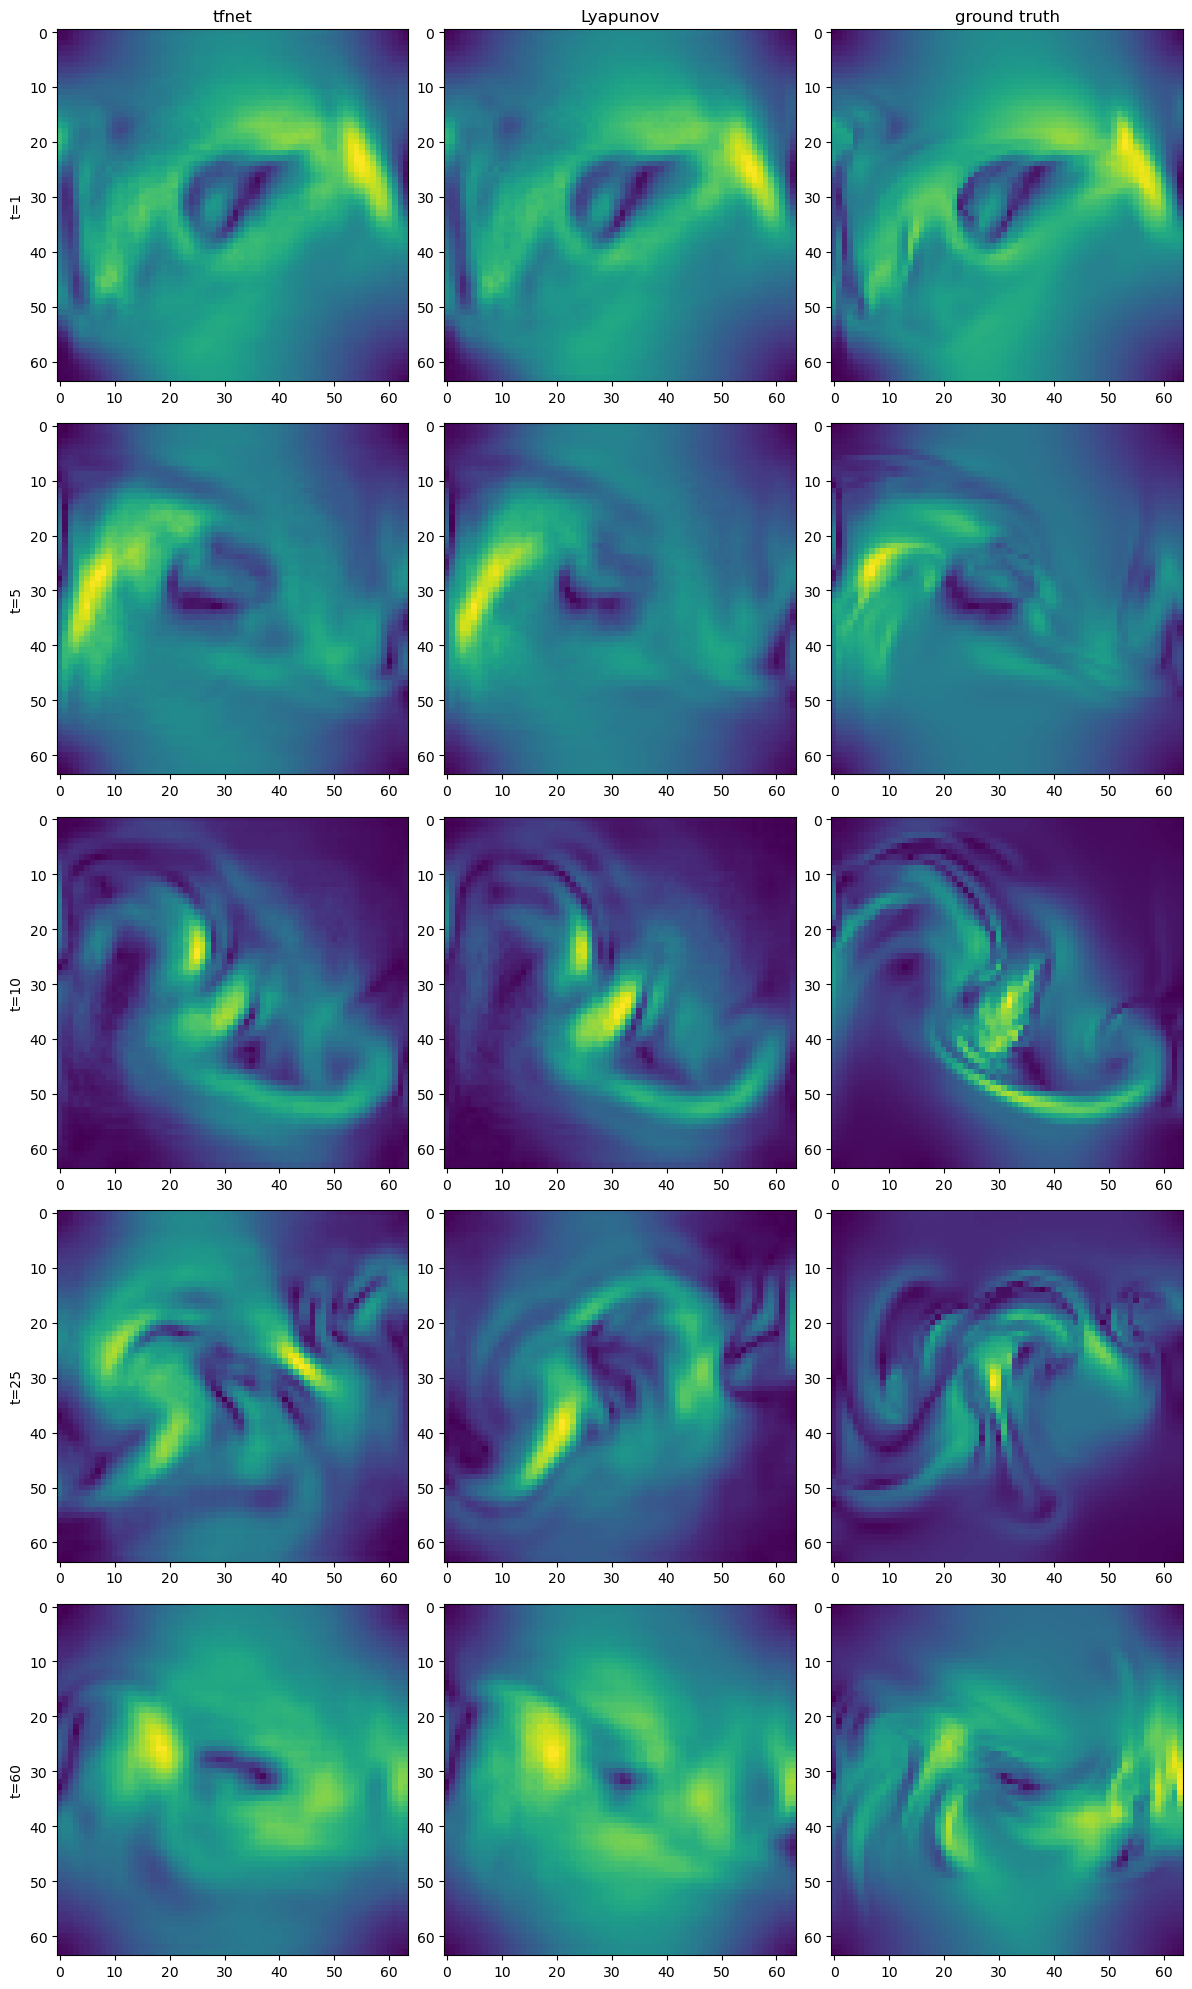

In [57]:
import matplotlib.pyplot as plt
time_arr = [0,4,9,24,59]
fig, axs_arr = plt.subplots(nrows=len(time_arr), ncols=len(preds)+1, figsize=(12,20))
for j, time in enumerate(time_arr):
    axs = axs_arr[j]
    batch_element=20
    images=np.linalg.norm(preds[:, batch_element, time], axis=1)
    # fig.suptitle(f"Predictions at {time} steps in future")
    for i, img in enumerate(images):
        axs[i].imshow(img)
    axs[-1].imshow(np.linalg.norm(trues[0, batch_element, time], axis=0))
titles = ["tfnet", "Lyapunov", "ground truth"]
assert len(titles) == len(preds) + 1 # +1 for GT 
for axs,ttl in zip(axs_arr[0], titles):
    axs.set_title(ttl)
for axs,time in zip(axs_arr[:,0], time_arr):
    axs.set_ylabel(f"t={time+1}")

fig.tight_layout()


In [14]:
describe(np.linalg.norm(preds[0][0,0], axis=0))

DescribeResult(nobs=4096, minmax=(0.007351535, 2.5891514), mean=0.61668587, variance=0.22736306662087913, skewness=1.1952912046327437, kurtosis=1.066808564729036)

# Work with test predictions

In [8]:
test_indices = list(range(7700, 9800))
input_length = args.input_length
time_range = args.time_range
batch_size = 21
kernel_size = args.kernel_size
dropout_rate = args.dropout_rate
device = "cuda:"
device_ids = [2]
args.path = "../results/tfnet_data9_101/tfnet_data9_101_17/"
args.pos_emb = args.pos_emb_dim > 0
args.use_test_mode = not args.not_use_test_mode

device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

model = LES(input_channels = input_length*2, output_channels = 2, kernel_size = kernel_size, dropout_rate = dropout_rate,
            time_range = time_range, addon_enc=args.addon_enc, addon_dec=args.addon_dec, time_emb_dim= args.pos_emb_dim).to(device)
# Note: saved_model is already in eval model, 
# this kind of trick is needed because the torch.save() stores the class file location.
# So some models use model addon file others use model file. But model.py simply imports from model_addon.py only
saved_model = torch.load(args.path+"model.pth", map_location=device).module
model.load_state_dict(saved_model.state_dict())
model.eval()    # If this is not used than saved_model and model inferences will be different

loss_fun = torch.nn.MSELoss()
best_model = nn.DataParallel(model, device_ids=device_ids)

data_prep = preprocess(args, permute, compress, test_mode=args.use_test_mode)

print("Testing in test setting")
test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, stack_x=True, test_mode=args.use_test_mode, test_mode_train=test_mode_train)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = args.num_workers)
preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun,test_mode=not test_mode_train and args.use_test_mode,device=device)

tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7f2e57dc1ca0> <function Scaler.fit_transform.<locals>.<lambda> at 0x7f2e57dc1ca0>
Testing in test setting


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]

[0.28502675 0.37668492 0.46453041 0.54781289 0.62564402 0.69682615
 0.76074402 0.81820188 0.869983   0.91590382 0.95566058 0.98952682
 1.01837509 1.04326873 1.06582872 1.08743009 1.1094729  1.1326509
 1.15626117 1.17900516 1.20070299 1.22152817 1.24070901 1.25823504
 1.27442298 1.28864086 1.30075922 1.31196491 1.32338493 1.33608662
 1.35099355 1.3675437  1.38462091 1.40234487 1.41980595 1.43627257
 1.45097921 1.46333382 1.47268122 1.47976994 1.48577928 1.49379492
 1.505259   1.51949875 1.53663576 1.55565811 1.57563168 1.59495348
 1.61208198 1.62589732 1.63639339 1.64512426 1.65336431 1.66114037
 1.67004444 1.68211701 1.6984443  1.71773497 1.73873528 1.75950888]


In [12]:
ndx = 52
ones = 0.1*np.ones_like(preds[ndx])
obs = np.concatenate((np.linalg.norm(preds[ndx],axis=1), np.linalg.norm(ones, axis=1), np.linalg.norm(trues[ndx], axis=1)),axis=2)
HTML(plot(torch.from_numpy(obs), 0))

In [21]:
print(stats.describe(preds, None))
print(stats.describe(trues, None))

DescribeResult(nobs=491520, minmax=(3.5527137e-15, 12.500872), mean=0.12217187, variance=0.13498804614496085, skewness=7.534581635282453, kurtosis=89.95575701694098)


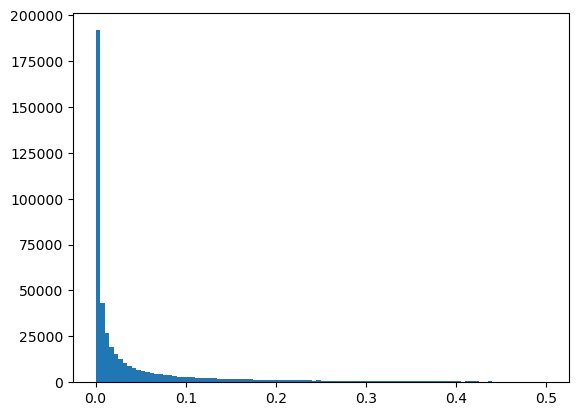

In [61]:
indx = 1157
errors = (trues[indx] - preds[indx])**2
_stats = stats.describe(errors, None)
print(_stats)
_max, _min = _stats.variance*3 + _stats.mean, _stats.mean - _stats.variance*3
plt.hist(errors.reshape(-1), range=(0, 0.5), bins=100);